In [2]:
%matplotlib inline
import IPython
import sys
sys.path.append('/home/localhorst87/Documents/coding/rl/finance/trading_rl/lib/')

from DataProvider import *
from Environment import *
from Learning import *
import Rewarder
import ActionSpace

import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import pdb
import math
import scipy.signal

First we configure the environment. As a first step we train an agent to open a position, based on a snapshots of 48 bars of 1 hour.
As the user should have a high level configurable parameter to set a risk at runtime, the agent returns a probability to make a positive return on investment.

The rewarder works with a time weighted cumulative return of each bar. We can configure the number of future samples to calculate the reward to configure the time span we want to trade on.

The agent uses a CNN with fully-connected layers an uses two separate networks for the mean and variance estimation. The network input is a fast, a medium and a slow MACD line, normed by the SMA of the last 480 samples

In [35]:
tf.reset_default_graph()

dataPath = '/home/localhorst87/Documents/coding/rl/finance/mult_hour_data.p'
windowLength = 48
actionSpace = ActionSpace.SeparatedNets()
rewarder = Rewarder.CumulativeWeightedOpeningRewarder()

env = Environment(dataPath, windowLength, actionSpace, rewarder)
agent = OpeningAgent(env)

Next we configure the hyper parameters:

We start with a risk of 50% probability to win. During the training we will lower the risk to 55% win probability (evaluation has turned out that the probability rarely exceeds values above 55%). That means: If the agent predicts a winning probability of over 50%, the agent will open a position (if both Long ans Short have a prediction over above this value, the agent chooses the higher rated action)

The agent uses an epsilon greedy strategy and we will use random actions for 10k samples. Then the random probability will be sloped down to zero after another 5k samples. When arriving zero random action probability we start to lower the risk.

As we use large batches (due to very noisy gradients when training a gaussian normal distribution), the training step size is reduced to 250 samples. The training will begin after 10k samples as we use a replay memory.

In [36]:
agent.probabilityThreshold = 0.50
agent.randomActionProbability = 1.00
agent.episodeStartTraining = 10000
agent.stepSizeTraining = 400
agent.batchSize = 1000
agent.learningRate = 4e-3

In [37]:
rewards = []
meanRewards = []
trainingLoss = []

Let's train the opening agent!

In [166]:
for _ in range(43500):
    
    reward, action, loss = agent.runEpisode()
    
    if action != "keep_observing": rewards.append(reward)
    meanRewards.append(np.mean(rewards[-1000:]))
    
    if loss is not None: trainingLoss.append(loss)

    if agent.episode > 10000 and agent.randomActionProbability > 0:
        agent.randomActionProbability -= 1.00/5000

    if agent.episode > 15000 and agent.probabilityThreshold < 0.55:
        agent.probabilityThreshold += (0.55-0.50)/25000
        
    if agent.episode > 10000 and agent.learningRate > 1e-3:
        agent.learningRate -= 3e-3/40000

    if agent.episode % 100 == 0:
        
        IPython.display.clear_output()
        
        print( "Episode " + str(agent.episode) + ") win prob opening threshold: " + str(round(agent.probabilityThreshold,2)) + \
          " // random action prob:" + str( round(agent.randomActionProbability,2) ) + \
          " // mean reward last 100 openings: " + str( round(np.mean(rewards[-100:]), 2) ) )
        
        plt.plot(meanRewards)
        plt.ylim(-0.1, 0.3)
        plt.grid()
        plt.show()
        plt.ylabel("mean rewards")

        plt.plot(trainingLoss)
        plt.grid()
        plt.show()
        plt.ylabel("training loss")

Let's have a look at the results:

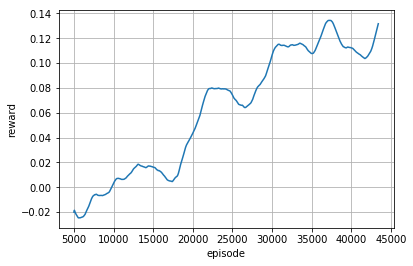

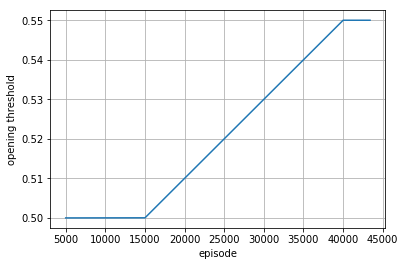

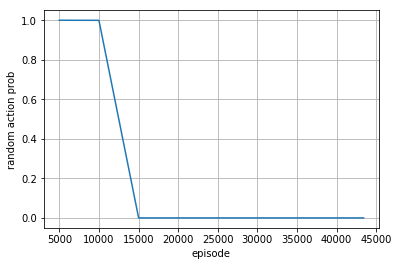

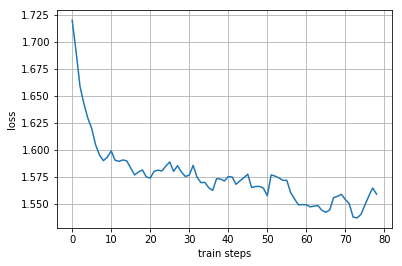

In [167]:
# rewards 
smoothedRewards = []
start = 5000
end = len(meanRewards)
for i in range(start,end): smoothedRewards.append(np.mean(meanRewards[i-5000:i]))
    
plt.plot(range(start,end), smoothedRewards)
plt.xlabel("episode")
plt.ylabel("reward")
plt.grid()
plt.show()

# opening threshold
threshLow = np.array([0.50]*10000)
threshSloping = np.linspace(0.50, 0.55, 25000)
threshHigh = np.array([0.55]*(len(meanRewards)-40000))
openingThrCurve = np.concatenate( (threshLow, threshSloping, threshHigh) )

plt.plot(range(start,end), openingThrCurve)
plt.xlabel("episode")
plt.ylabel("opening threshold")
plt.grid()
plt.show()

# random probability
randomHigh = np.array([1.00]*5000)
randomSlopingDown = threshSloping = np.linspace(1.00, 0.00, 5000)
randomLow = np.array([0.00]*(len(meanRewards)-15000))
randomCurve = np.concatenate( (randomHigh, randomSlopingDown, randomLow) )
    
plt.plot(range(start,end), randomCurve)
plt.xlabel("episode")
plt.ylabel("random action prob")
plt.grid()
plt.show()

# training loss
smoothedLoss = []
for i in range(5, len(trainingLoss)): smoothedLoss.append(np.mean(trainingLoss[i-5:i]))

plt.plot(range(len(smoothedLoss)), smoothedLoss)
plt.xlabel("train steps")
plt.ylabel("loss")
plt.grid()
plt.show()

We can see a mean reward after ~43500 episodes of approximately 0.13 ... We must take into account that it's just the expected mean reward after opening a position and closing the position randomly! The next step is to train a closing agent to gain the maximum ROI of an open position.
checking our agent for plausability, it's striking that the mean probability to gain positive ROI (with this particular configuration of input data and reward system) does rarerly exceed values of 55%. After all, positive returns in trading is just the right way to handle your risk!

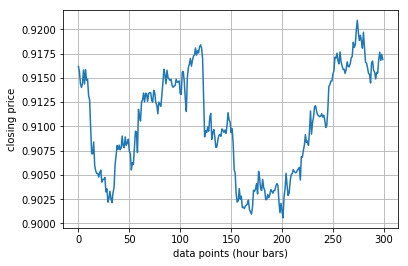

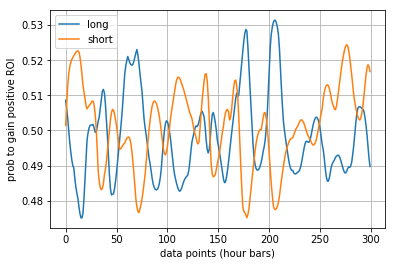

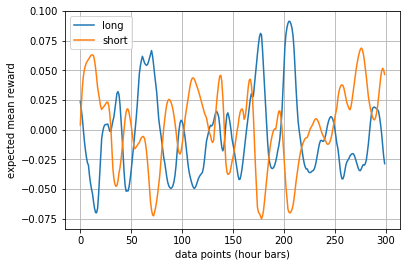

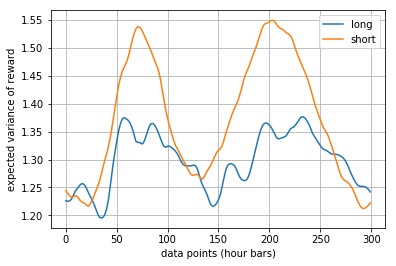

In [196]:
observation = agent.environment.reset()
state = agent._createInput(observation)
winProbLong = []
winProbShort = []
meanLong= []
meanShort = []
varLong = []
varShort = []

tradingState = "observe"

while tradingState == "observe" and agent.environment.dataset.getRemainingSamples() > 100:
    mean, var = agent._getEstimation(state)
    meanLong.append(mean[0])
    meanShort.append(mean[1])
    varLong.append(var[0])
    varShort.append(var[1])
    winProbLong.append(agent._calcWinProb(mean[0], var[0]))
    winProbShort.append(agent._calcWinProb(mean[1], var[1]))
    nextObservation, _, tradingState, _ = agent.environment.step("keep_observing")
    state = agent._createInput(nextObservation)

plt.plot(agent.environment.dataset.data["price_ask_close"].values[48:348])
plt.xlabel("data points (hour bars)")
plt.ylabel("closing price")
plt.grid()
plt.show()

plt.plot(winProbLong[:300], label='long')
plt.plot(winProbShort[:300], label='short')
plt.xlabel("data points (hour bars)")
plt.ylabel("prob to gain positive ROI")
plt.legend()
plt.grid()
plt.show()

plt.plot(meanLong[:300], label='long')
plt.plot(meanShort[:300], label='short')
plt.xlabel("data points (hour bars)")
plt.ylabel("expected mean reward")
plt.legend()
plt.grid()
plt.show()

plt.plot(varLong[:300], label='long')
plt.plot(varShort[:300], label='short')
plt.xlabel("data points (hour bars)")
plt.ylabel("expected variance of reward")
plt.legend()
plt.grid()
plt.show()